In [68]:
import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, parent_dir)
import src

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import glob

We can take our preprocessed data, chunk it into smaller bits of data -- like 2min or something -- then use resampling to generate fixed-length signals that can be fed into an LSTM.

In [169]:
random_file = np.random.choice(glob.glob('../data/preprocessed/*'))
print(random_file)
df = pd.read_csv(random_file, index_col='ptime')
df.index = pd.to_timedelta(df.index)
df = src.features.extend(df, src.features.extending.inter_arrival_time)
resampled = df.resample('100ms').sum().reset_index()
slice_indices = np.argwhere(
    resampled.ptime.isin(
        pd.timedelta_range(resampled.ptime.min(), resampled.ptime.max(), freq='90s')
    )
    .values
).ravel()
chunks = np.split(resampled, slice_indices)[1:-1]

../data/preprocessed/streaming-apristin-youtube[1440p60]-1x-vpn-windows-noisy-20201102-0.csv


<AxesSubplot:>

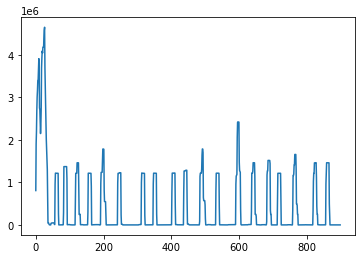

In [170]:
signal = chunks[0].rolling('1s', on='ptime').psize.sum()
signal.plot()

In [186]:
tuple(signal.values)

(808654.0,
 1902246.0,
 2191366.0,
 2685019.0,
 3007992.0,
 3174466.0,
 3399992.0,
 3421442.0,
 3667827.0,
 3912879.0,
 3599311.0,
 2752711.0,
 2708751.0,
 2462114.0,
 2150081.0,
 2368342.0,
 2755305.0,
 3689111.0,
 3937056.0,
 4092351.0,
 4044258.0,
 4181282.0,
 4183184.0,
 4181798.0,
 4386925.0,
 4582062.0,
 4652093.0,
 3696837.0,
 3202507.0,
 2827778.0,
 2396226.0,
 2014219.0,
 1767157.0,
 1521527.0,
 1305460.0,
 725588.0,
 43068.0,
 43230.0,
 43604.0,
 17986.0,
 2545.0,
 536.0,
 536.0,
 536.0,
 536.0,
 36584.0,
 42310.0,
 45456.0,
 45208.0,
 47030.0,
 47282.0,
 47803.0,
 47803.0,
 47803.0,
 47803.0,
 11755.0,
 7815.0,
 961984.0,
 1218550.0,
 1216728.0,
 1216476.0,
 1215955.0,
 1216081.0,
 1216081.0,
 1216081.0,
 1216451.0,
 1214665.0,
 257188.0,
 496.0,
 496.0,
 496.0,
 496.0,
 370.0,
 370.0,
 370.0,
 0.0,
 1011.0,
 1947.0,
 1947.0,
 1947.0,
 1947.0,
 3733.0,
 288207.0,
 1371897.0,
 1371897.0,
 1371897.0,
 1370886.0,
 1369950.0,
 1370076.0,
 1370076.0,
 1370076.0,
 1372488.0,
 1088

In [171]:
len(signal)

900

Time to build an LSTM that takes in length 900 inputs.

In [203]:
from ast import literal_eval
data = pd.read_csv('../data/features/features_signals.csv')
data.signal = data.signal.apply(literal_eval)
data.head()

,file,activity,signal
0,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(205.0, 205.0, 205.0, 337.0, 1826.0, 2171.0, 1..."
1,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(266.0, 266.0, 266.0, 266.0, 266.0, 266.0, 266..."
2,stdoan-youtube[1080p60]-1x-vpn-windows-clean-2...,streaming,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,mhrowlan_youtube_240p_2x_vpn_mac_clean_2020110...,streaming,"(682.0, 682.0, 682.0, 682.0, 682.0, 682.0, 682..."
4,mhrowlan_youtube_240p_2x_vpn_mac_clean_2020110...,streaming,"(0.0, 0.0, 0.0, 12176.0, 14912.0, 16967.0, 169..."


In [246]:
X = np.array([
    np.array(s, ndmin=2) for s in data.signal
])
y = (data.activity.values == 'streaming').astype(int)

In [247]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [265]:
np.mean(y_train)

0.748062015503876

In [262]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [263]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
9/9 [==============================] - 0s 37ms/step - loss: 0.6845 - accuracy: 0.5698
Epoch 2/50
9/9 [==============================] - 0s 42ms/step - loss: 0.6717 - accuracy: 0.5930
Epoch 3/50
9/9 [==============================] - 0s 35ms/step - loss: 0.6639 - accuracy: 0.6008
Epoch 4/50
9/9 [==============================] - 0s 25ms/step - loss: 0.6569 - accuracy: 0.6163
Epoch 5/50
9/9 [==============================] - 0s 30ms/step - loss: 0.6505 - accuracy: 0.6395
Epoch 6/50
9/9 [==============================] - 0s 32ms/step - loss: 0.6441 - accuracy: 0.6473
Epoch 7/50
9/9 [==============================] - 0s 31ms/step - loss: 0.6381 - accuracy: 0.6512
Epoch 8/50
9/9 [==============================] - 0s 23ms/step - loss: 0.6330 - accuracy: 0.6512
Epoch 9/50
9/9 [==============================] - 0s 22ms/step - loss: 0.6272 - accuracy: 0.6589
Epoch 10/50
9/9 [==============================] - 0s 22ms/step - loss: 0.6217 - accuracy: 0.6744
Epoch 11/50
9/9 [============